# CFA

Bu notebook'ta, ahşap yüzeylerdeki anomalileri tespit etmek için bir *CFA* modeli geliştirilecek ve eğitilecektir.

## 1. Ortam Kurulumu


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!mkdir CFA
%cd /content/drive/MyDrive/CFA

mkdir: cannot create directory ‘CFA’: File exists
/content/drive/MyDrive/CFA


## 2. Gerekli Kütüphanelerin Kurulumu ve İçe Aktarımı

In [4]:
!pip install anomalib[full]

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image

#Anomalib'den gerekli modüller
from anomalib.data import Folder
from anomalib.models import Cfa
from anomalib.engine import Engine
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import Dataset, DataLoader
from anomalib.metrics import Evaluator, AnomalibMetric
from anomalib.metrics.threshold import F1AdaptiveThreshold, ManualThreshold
from torchmetrics.classification import BinaryF1Score, BinaryRecall,BinaryAccuracy, BinaryPrecision

/usr/local/lib/python3.11/dist-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## 3. Veriseti  Yapılandırması

Anomalib'in veri modüllerini kullanarak veri setini Cfa modeline uygun hale getirme. `Folder` modülü kullanılarak klasör yapısına dayalı bir veri seti tanımlanır.

**Parametre Açıklamaları:**
- `name`: Veri setine verilen isim.
- `root`: Veri setinin ana dizini.
- `normal_dir`: Eğitim için normal görüntülerin bulunduğu alt dizin.
- `normal_test_dir`: Test için normal görüntülerin bulunduğu alt dizin.
- `mask_dir`: Anomali maskelerinin bulunduğu alt dizin.
- `abnormal_dir`: Test için anormal görüntülerin bulunduğu alt dizin.
- `test_split_mode`: Test verisinin nasıl ayrılacağını belirtir ('from_dir' klasör yapısına göre).
- `train_batch_size`: Eğitim batch boyutu.
- `eval_batch_size`: Değerlendirme/Test batch boyutu.
- `num_workers`: Veri yükleme için kullanılacak alt işlem sayısı.

In [6]:
DATASET_PATH = "/content/drive/MyDrive/processed_dataset/wood" #Veri Setinin Kök Dizini

In [7]:
datamodule = Folder(
    name = "wood_dataset",
    root = DATASET_PATH,
    normal_dir="train/good",
    normal_test_dir="test/good",
    mask_dir="ground_truth/defect",
    abnormal_dir="test/defect",
    test_split_mode= "from_dir",

    train_batch_size=8,
    eval_batch_size=8,
    num_workers=2,
)

##4. Metrik Yapılandırması

Modelin performansını değerlendirmek için kullanılacak metriklerin tanımlaanması. Anomalib'in `Evaluator`'ı bu metrikleri test sırasında otomatik olarak hesaplayacaktır.
Özel metrik sınıfları, PyTorch-Lightning'in `torchmetrics`'i ile Anomalib'in `AnomalibMetric`'ini birleştirir.


In [8]:
class Accuracy(AnomalibMetric, BinaryAccuracy):
    pass

class F1Score(AnomalibMetric, BinaryF1Score):
    pass

class Recall(AnomalibMetric, BinaryRecall):
    pass

class Precision(AnomalibMetric, BinaryPrecision):
    pass

binary_accuracy = Accuracy(fields=["pred_label", "gt_label"])
binary_f1_score = F1Score(fields=["pred_label", "gt_label"])
binary_recall = Recall(fields=["pred_label", "gt_label"])
binary_precision = Precision(fields=["pred_label", "gt_label"])

threshold_metrics = [
    F1AdaptiveThreshold(fields=["pred_score", "gt_label"]),  # Otomatik eşik
    ManualThreshold(default_value=0.5),  # 0.5 eşik değeri
    ManualThreshold(default_value=0.3),  # 0.3 eşik değeri
    ManualThreshold(default_value=0.7)   # 0.7 eşik değeri
]
metrics = [
    binary_accuracy,
    binary_f1_score,
    binary_recall,
    binary_precision,

]


evaluator = Evaluator(test_metrics=metrics)


## 5. Model Yapılandırması ve Eğitimi

Cfa modelini tanımlanamsı ve PyTorch Lightning tabanlı `Engine` kullanarak eğitim sürecinin yönetilmesi.

**Model Parametreleri:**
- `backbone`: Modelin temelini oluşturan önceden eğitilmiş ağ ('wide_resnet50_2').
- `visualizer`: Eğitim veya test sırasında görselleştirmelerin yapılıp yapılmayacağı.
- `evaluator`: Test sırasında kullanılacak metrikleri içeren Evaluator nesnesi.

**Engine Parametreleri:**
- `max_epochs`: Eğitimin kaç epoch süreceği.
- `logger`: Eğitim loglarının kaydedileceği logger (CSVLogger veya TensorBoardLogger gibi).



In [9]:
model = Cfa(
    backbone = "wide_resnet50_2",
    visualizer=True,
    evaluator=evaluator
)

logger = CSVLogger(save_dir="/content/drive/MyDrive/CFA", name = "Cfa_logs")

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'evaluator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['evaluator'])`.
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cach

### 5.1 30 Epoch İle Eğitim

In [10]:
engine = Engine(max_epochs = 30, logger = logger)

engine.fit(model, datamodule=datamodule)
predictions = engine.predict(model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | pre_processor  | PreProcessor  | 0      | train
1 | post_processor | PostProcessor | 0      | trai

Training: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 9/9 [00:22<00:00,  2.51s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [11]:
test_results = engine.test(model, datamodule=datamodule)
print("Test Sonuçları:", test_results)

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.7887324094772339     │
│          F1Score          │    0.8051947951316833     │
│         Precision         │    0.7560975551605225     │
│          Recall           │    0.8611111044883728     │
└───────────────────────────┴───────────────────────────┘

Test Sonuçları: [{'Accuracy': 0.7887324094772339, 'F1Score': 0.8051947951316833, 'Recall': 0.8611111044883728, 'Precision': 0.7560975551605225}]


In [12]:
save_path = "/content/drive/MyDrive/CFA/cfa_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model ağırlıkları '{save_path}' dosyasına kaydedildi.")

Model ağırlıkları '/content/drive/MyDrive/CFA/cfa_model.pth' dosyasına kaydedildi.


## 6. Performans Değerlendirmesi ve Görselleştirme

Modelin tahmin ettiği anomali haritaları kullanılarak optimal bir piksel eşiği hesaplanmakta, bu eşik kullanılarak ikili maskeler oluşturulmakta ve bu tahmin edilen maskeler gerçek (Ground Truth) maskelerle karşılaştırılarak IoU (Intersection over Union) değerleri hesaplanmakta ve görselleştirilmektedir.

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


F1AdaptiveThreshold ile Hesaplanan Optimal Piksel Eşiği: 0.4767

İlk 5 Resim İçin Maske Karşılaştırması ve IoU Dğerleri (Hesaplanan Eşik: 0.4767 İle):
Resim 1 (100000000.jpg): IoU = 0.0357


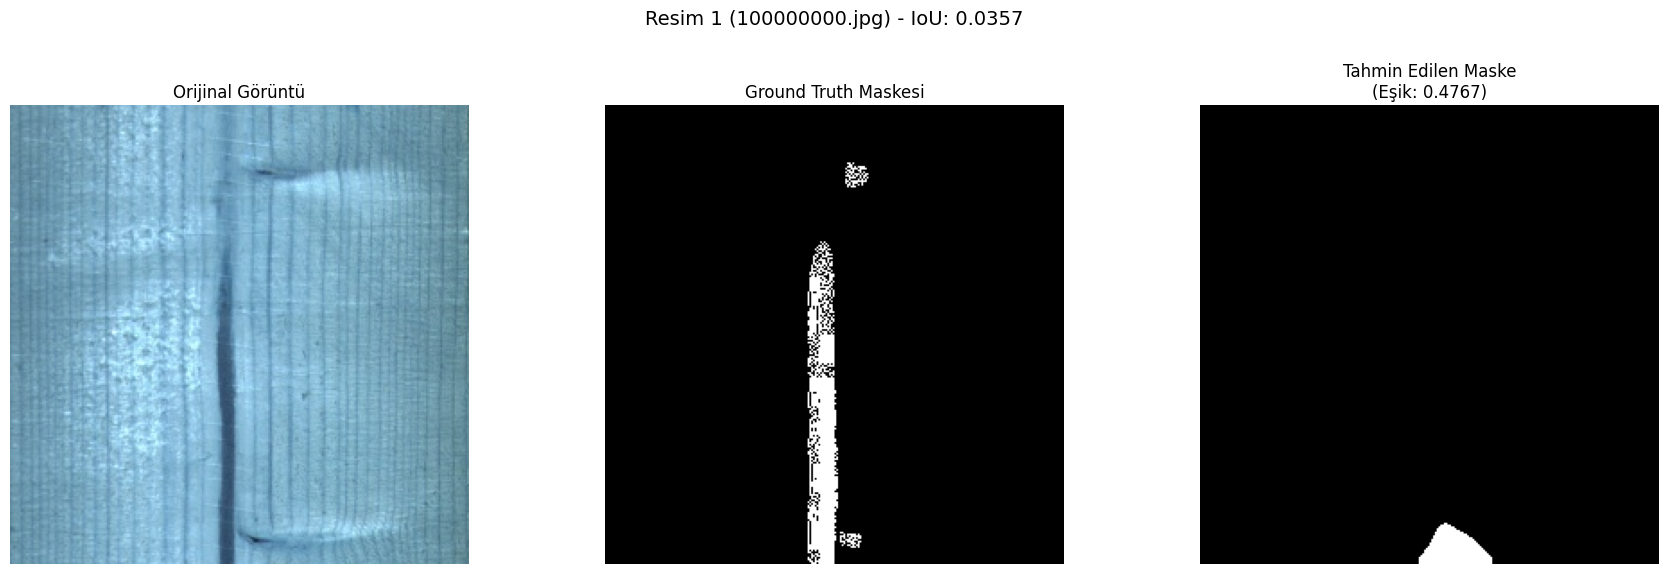

Resim 2 (100000003.jpg): IoU = 0.3610


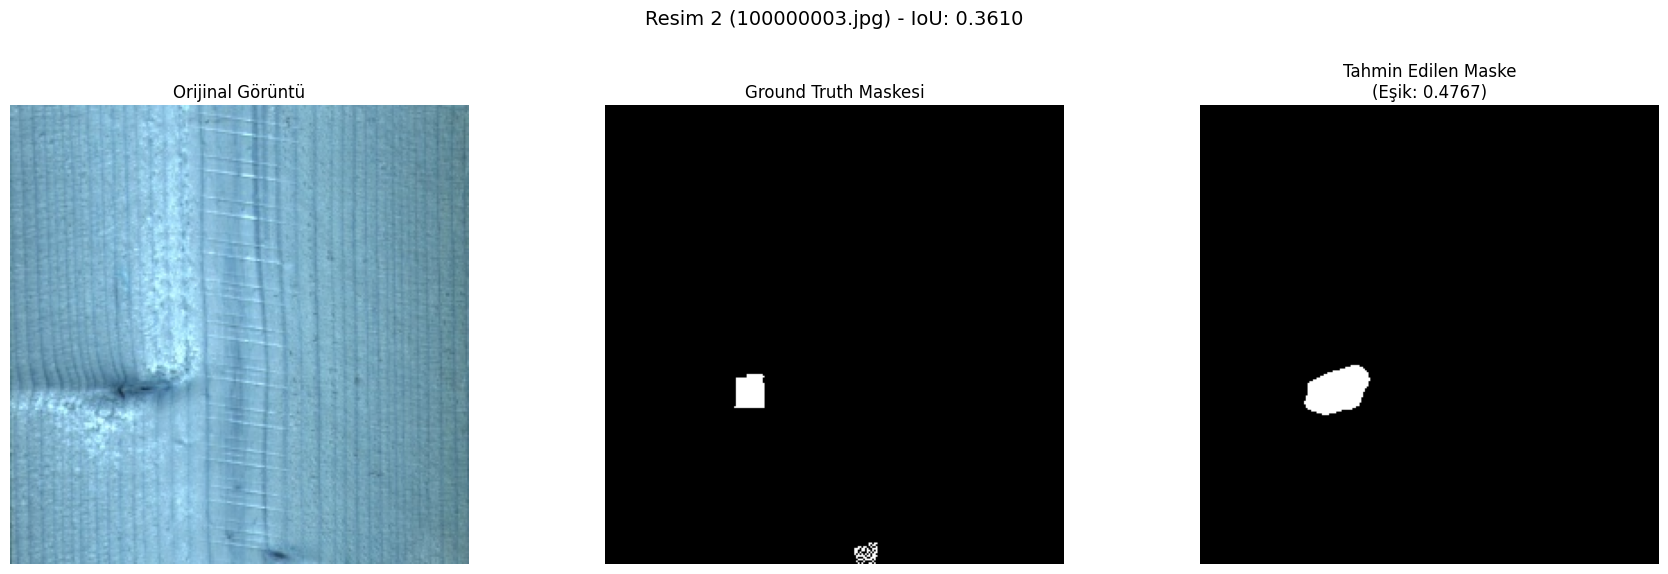

Resim 3 (100000009.jpg): IoU = 0.1907


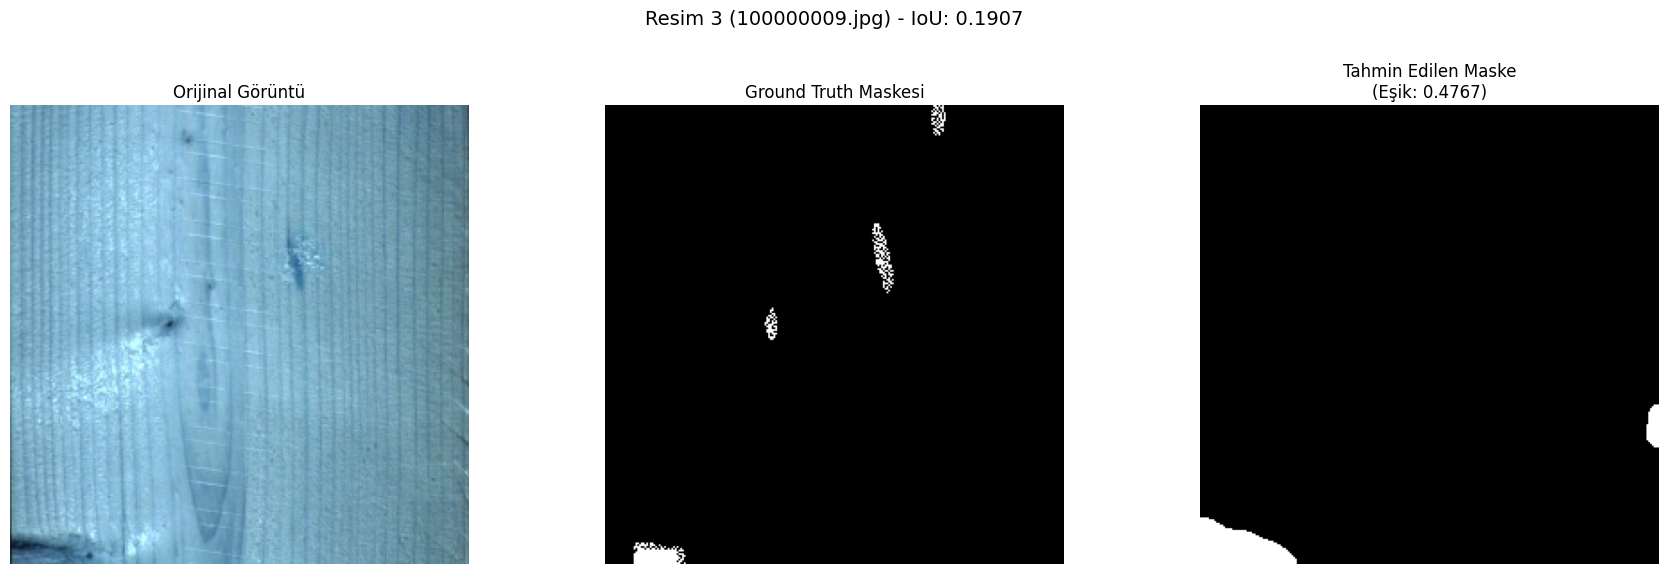

Resim 4 (100000012.jpg): IoU = 0.0182


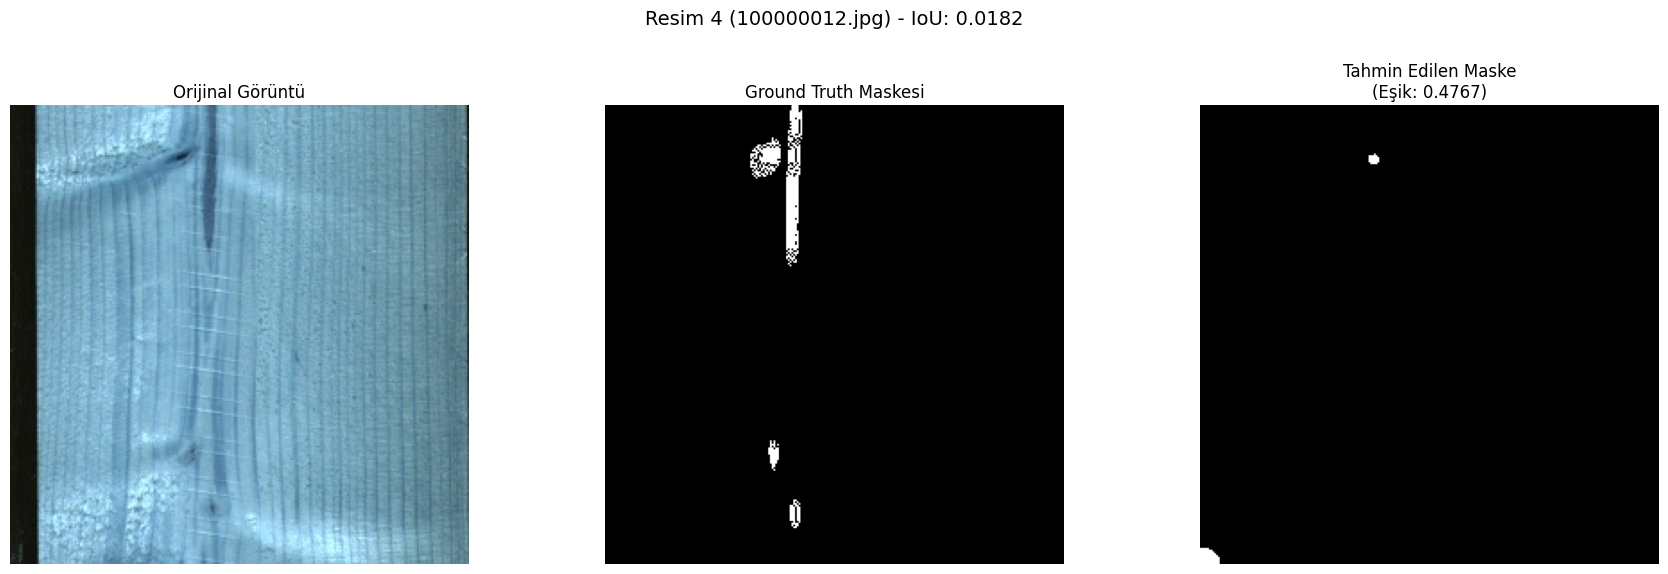

Resim 5 (100000016.jpg): IoU = 0.0527


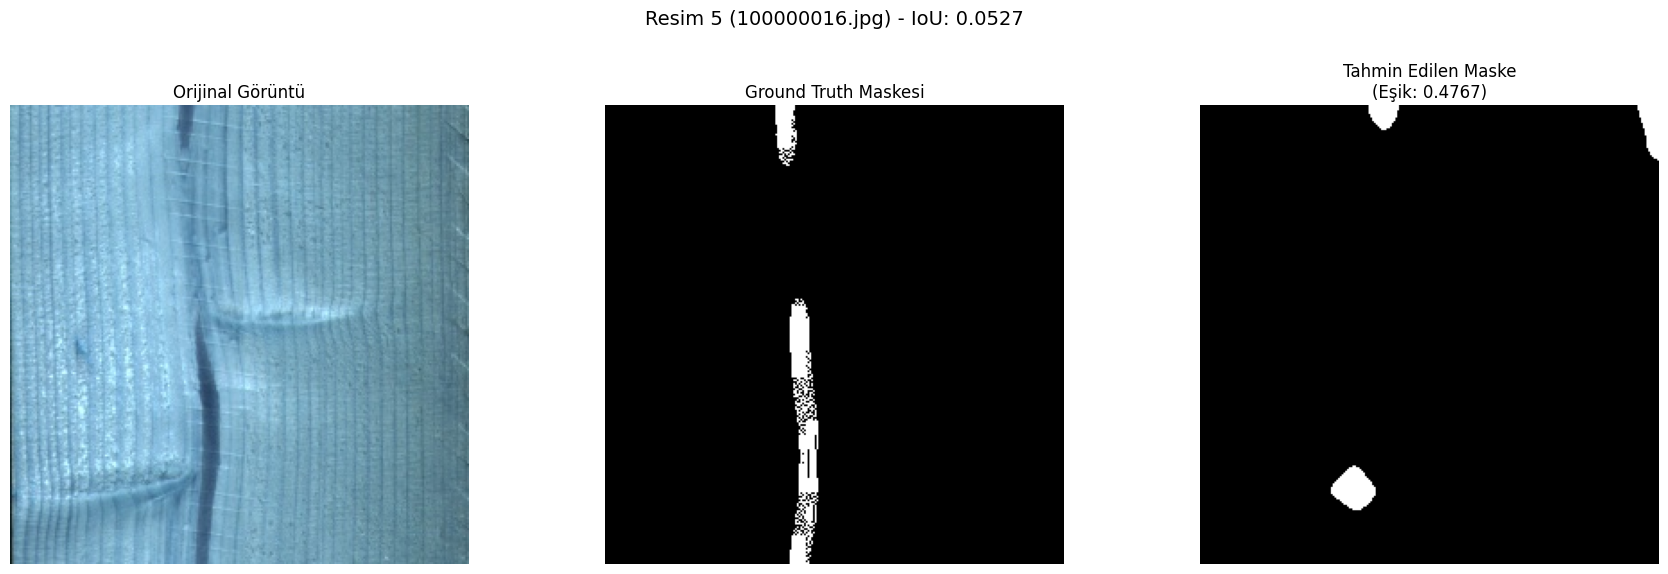


Gösterilen 5 Maskeli Resim İçin Ortalama IoU: 0.1317


In [14]:
from anomalib.metrics.threshold import F1AdaptiveThreshold
import cv2
import numpy as np
from PIL import Image


f1_threshold_finder = F1AdaptiveThreshold(fields=["anomaly_map", "gt_mask"])

all_predictions_batches = engine.predict(model, datamodule=datamodule)


processed_batches_for_threshold = 0
for batch_item in all_predictions_batches:
    if batch_item.gt_mask is not None and hasattr(batch_item, 'anomaly_map') and batch_item.anomaly_map is not None:
         try:
            f1_threshold_finder.update(batch_item)
            processed_batches_for_threshold += 1
         except Exception as e:
             print(f"Uyarı: Bir batch işlenirken hata oluştu (Eşik update): {e}. Batch atlanıyor.")


try:
    computed_f1_threshold = f1_threshold_finder.compute()
    print(f"\nF1AdaptiveThreshold ile Hesaplanan Optimal Piksel Eşiği: {computed_f1_threshold.item():.4f}")
except Exception as e:
     print(f"\n!!! Hata: F1AdaptiveThreshold compute() metodunda hata oluştu: {e}")
     print("!!! Geçici olarak varsayılan 0.5 eşiği kullanılacaktır.")
     computed_f1_threshold = torch.tensor(0.5)

optimal_threshold = computed_f1_threshold.item()


# İki ikili maske arasındaki IoU'yu hesaplayan fonksiyon
def calculate_iou(mask1, mask2):
    mask1 = np.asarray(mask1, dtype=bool)
    mask2 = np.asarray(mask2, dtype=bool)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

num_images_to_visualize = 5
processed_image_count = 0
subset_iou_scores = []

print(f"\nİlk {num_images_to_visualize} Resim İçin Maske Karşılaştırması ve IoU Dğerleri (Hesaplanan Eşik: {optimal_threshold:.4f} İle):")

# Saklanan prediction batch listesi üzerinde döngü yap
for batch_item in all_predictions_batches:
    batch_size = len(batch_item.image_path)

    for j in range(batch_size):
        if processed_image_count >= num_images_to_visualize:
            break

        current_image_path = batch_item.image_path[j]
        current_gt_mask_tensor = batch_item.gt_mask[j] if batch_item.gt_mask is not None and j < len(batch_item.gt_mask) else None
        current_anomaly_map_tensor = batch_item.anomaly_map[j] if batch_item.anomaly_map is not None and j < len(batch_item.anomaly_map) else None

        try:
            anomaly_map_np = current_anomaly_map_tensor.squeeze().cpu().numpy()
            ground_truth_mask_np = current_gt_mask_tensor.squeeze().cpu().numpy() if current_gt_mask_tensor is not None else np.zeros_like(anomaly_map_np)
        except Exception as e:
            print(f"Hata: Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}) tensorları numpy'ye çevirirken hata oluştu: {e}. Atlanıyor.")
            continue

        ground_truth_mask_binary = ground_truth_mask_np > 0

        smoothed_map_np = cv2.GaussianBlur(anomaly_map_np, (5, 5), 0)

        predicted_mask_binary = smoothed_map_np > optimal_threshold

        iou = -1
        if current_gt_mask_tensor is not None:
             try:
                iou = calculate_iou(ground_truth_mask_binary, predicted_mask_binary)
                subset_iou_scores.append(iou)
                print(f"Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}): IoU = {iou:.4f}")
             except Exception as e:
                print(f"Hata: Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}) için IoU hesaplarken hata oluştu: {e}.")
                continue

        else:
             print(f"Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}): GT Maske Yok. IoU Hesaplanmadı.")


        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        try:
            original_image_pil = Image.open(current_image_path).convert("RGB")
            axes[0].imshow(original_image_pil)
            axes[0].set_title("Orijinal Görüntü")
            axes[0].axis('off')
        except Exception as e:
            print(f"Hata: Resim {processed_image_count + 1} ({current_image_path}) yüklenirken hata oluştu: {e}. Gösterilemiyor.")
            axes[0].set_title("Görüntü Yükleme Hatası")
            axes[0].axis('off')

        axes[1].imshow(ground_truth_mask_binary, cmap='gray')
        axes[1].set_title("Ground Truth Maskesi" if current_gt_mask_tensor is not None else "GT Maske Yok")
        axes[1].axis('off')

        axes[2].imshow(predicted_mask_binary, cmap='gray')
        axes[2].set_title(f"Tahmin Edilen Maske\n(Eşik: {optimal_threshold:.4f})")
        axes[2].axis('off')

        main_title = f"Resim {processed_image_count + 1} ({os.path.basename(current_image_path)})"
        if iou != -1:
            main_title += f" - IoU: {iou:.4f}"
        plt.suptitle(main_title, fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()

        processed_image_count += 1

    if processed_image_count >= num_images_to_visualize:
        break

if subset_iou_scores:
      average_iou_subset = sum(subset_iou_scores) / len(subset_iou_scores)
      print(f"\nGösterilen {len(subset_iou_scores)} Maskeli Resim İçin Ortalama IoU: {average_iou_subset:.4f}")
else:
      print("\nHiçbir maskeli resim başarıyla işlenemedi veya gösterilecek yeterli maskeli resim bulunamadı.")

In [ ]:
all_iou_scores = []

for batch_item in all_predictions_batches:
    batch_size = len(batch_item.image_path)

    for j in range(batch_size):
        current_gt_mask_tensor = batch_item.gt_mask[j] if batch_item.gt_mask is not None and j < len(batch_item.gt_mask) else None
        current_anomaly_map_tensor = batch_item.anomaly_map[j] if batch_item.anomaly_map is not None and j < len(batch_item.anomaly_map) else None

        if current_gt_mask_tensor is None or current_anomaly_map_tensor is None:
            continue

        try:
            anomaly_map_np = current_anomaly_map_tensor.squeeze().cpu().numpy()
            ground_truth_mask_np = current_gt_mask_tensor.squeeze().cpu().numpy()
        except Exception as e:
            print(f"Hata: Tensorları numpy'ye çevirirken hata oluştu: {e}. Atlanıyor.")
            continue

        ground_truth_mask_binary = ground_truth_mask_np > 0
        smoothed_map_np = cv2.GaussianBlur(anomaly_map_np, (5, 5), 0)
        predicted_mask_binary = smoothed_map_np > optimal_threshold

        try:
            iou = calculate_iou(ground_truth_mask_binary, predicted_mask_binary)
            all_iou_scores.append(iou)
        except Exception as e:
            print(f"IoU hesaplanırken hata oluştu: {e}.")
            continue

if all_iou_scores:
    overall_average_iou = sum(all_iou_scores) / len(all_iou_scores)
    print(f"\nTüm Resimler İçin Ortalama IoU: {overall_average_iou:.4f}")
else:
    print("\nHiçbir resim başarıyla işlenemedi. Ortalama IoU hesaplanamadı.")



Tüm Resimler İçin Ortalama IoU: 0.3599
